**COSC343 Report: Assignment 02, Genetic Algorithms**

Author: *Jack MacCormick - 2148113*

Due Date: *Tuesday 18th May*

**Outline**

The purpose of this assignment was to demonstrate the mechanics of genetic algorithms, through an agent based game. The game can be defined as *a team-based competitive multiagent environment*, in which agents comsume a static resource, or hostile agents smaller than themselves. The side with the most agents left after 100 turns (all agents move once per turn) wins, irregardless of the size of those surviving agents. 

This game is similar to the game Agar.io, however somewhat simplified to reduce the complexity of the problem. Agents travel along a wrap-around grid space, travelling a fixed distance of 1 square per turn/move action. 

The genetic agent is initalised to a random state, and plays games against either a *"random"* or a *"hunter"* player. After each game, the genetic agent population is evaluated against a predetermined fitness function, and well preforming agents are allowed to propagate the next generation. This new generation plays the next game, and so forth.
Ideally, through itterative games, the genetic algorithm should converge on a winning strategy, however the convergence is determined by the fitness function, not by wins||losses, so this function must be well defined such that it promotes winning behaviours.

Agents are able to perceive up to 2 tiles away from themselves in any direction (including diagonally), creating a 5x5 percept map. The environment's three features, other agents, food items and walls, are seperated onto different percept layers, and do not obscure vision to other tiles. This means the environment is not fully known to any given agent. Further, as agents do not communicate with each other, they do not form a larger world map from the small pieces each agent perceives.

**Strategies**

***Choice of algorithm:***

For creating the generations, traditional genetic algorithms combine the genes of a fixed number of parents, creating a "raw" chromosome, this raw chromosome is then subject to some random variation, mimicking biological mutation. 

Alternatively, there is a branch of genetic algorithms which use *"Differential Evolution"*, where creatures have a chance to displace creatures from the previous generation if their fitness score is higher than the old creature's score. The creation of new creatures is also slightly different, but is not sufficently different to warrant explanation here. 

As differential evolution (DE) requiures fitness evalations of each new agent to be compared against those of old before the swap happens, implementing DE in this context would require a full back up of prior generations, as fitness is only calaculated after a full game, involving multiple agents. Because of this constraint, DE was not chosen as my genetic algorithm format for this assignment. 

Instead, the genetic implementation used for this assignment allows the top *x*% of the generation to propagate new children, and the upper half of that propagating group to survive into the next generation; *at a threshold of 30%, of 100 agents, the top 30 agents would be used to create new agents, and the top 15 within that subset would **also** survive through into the next generation:
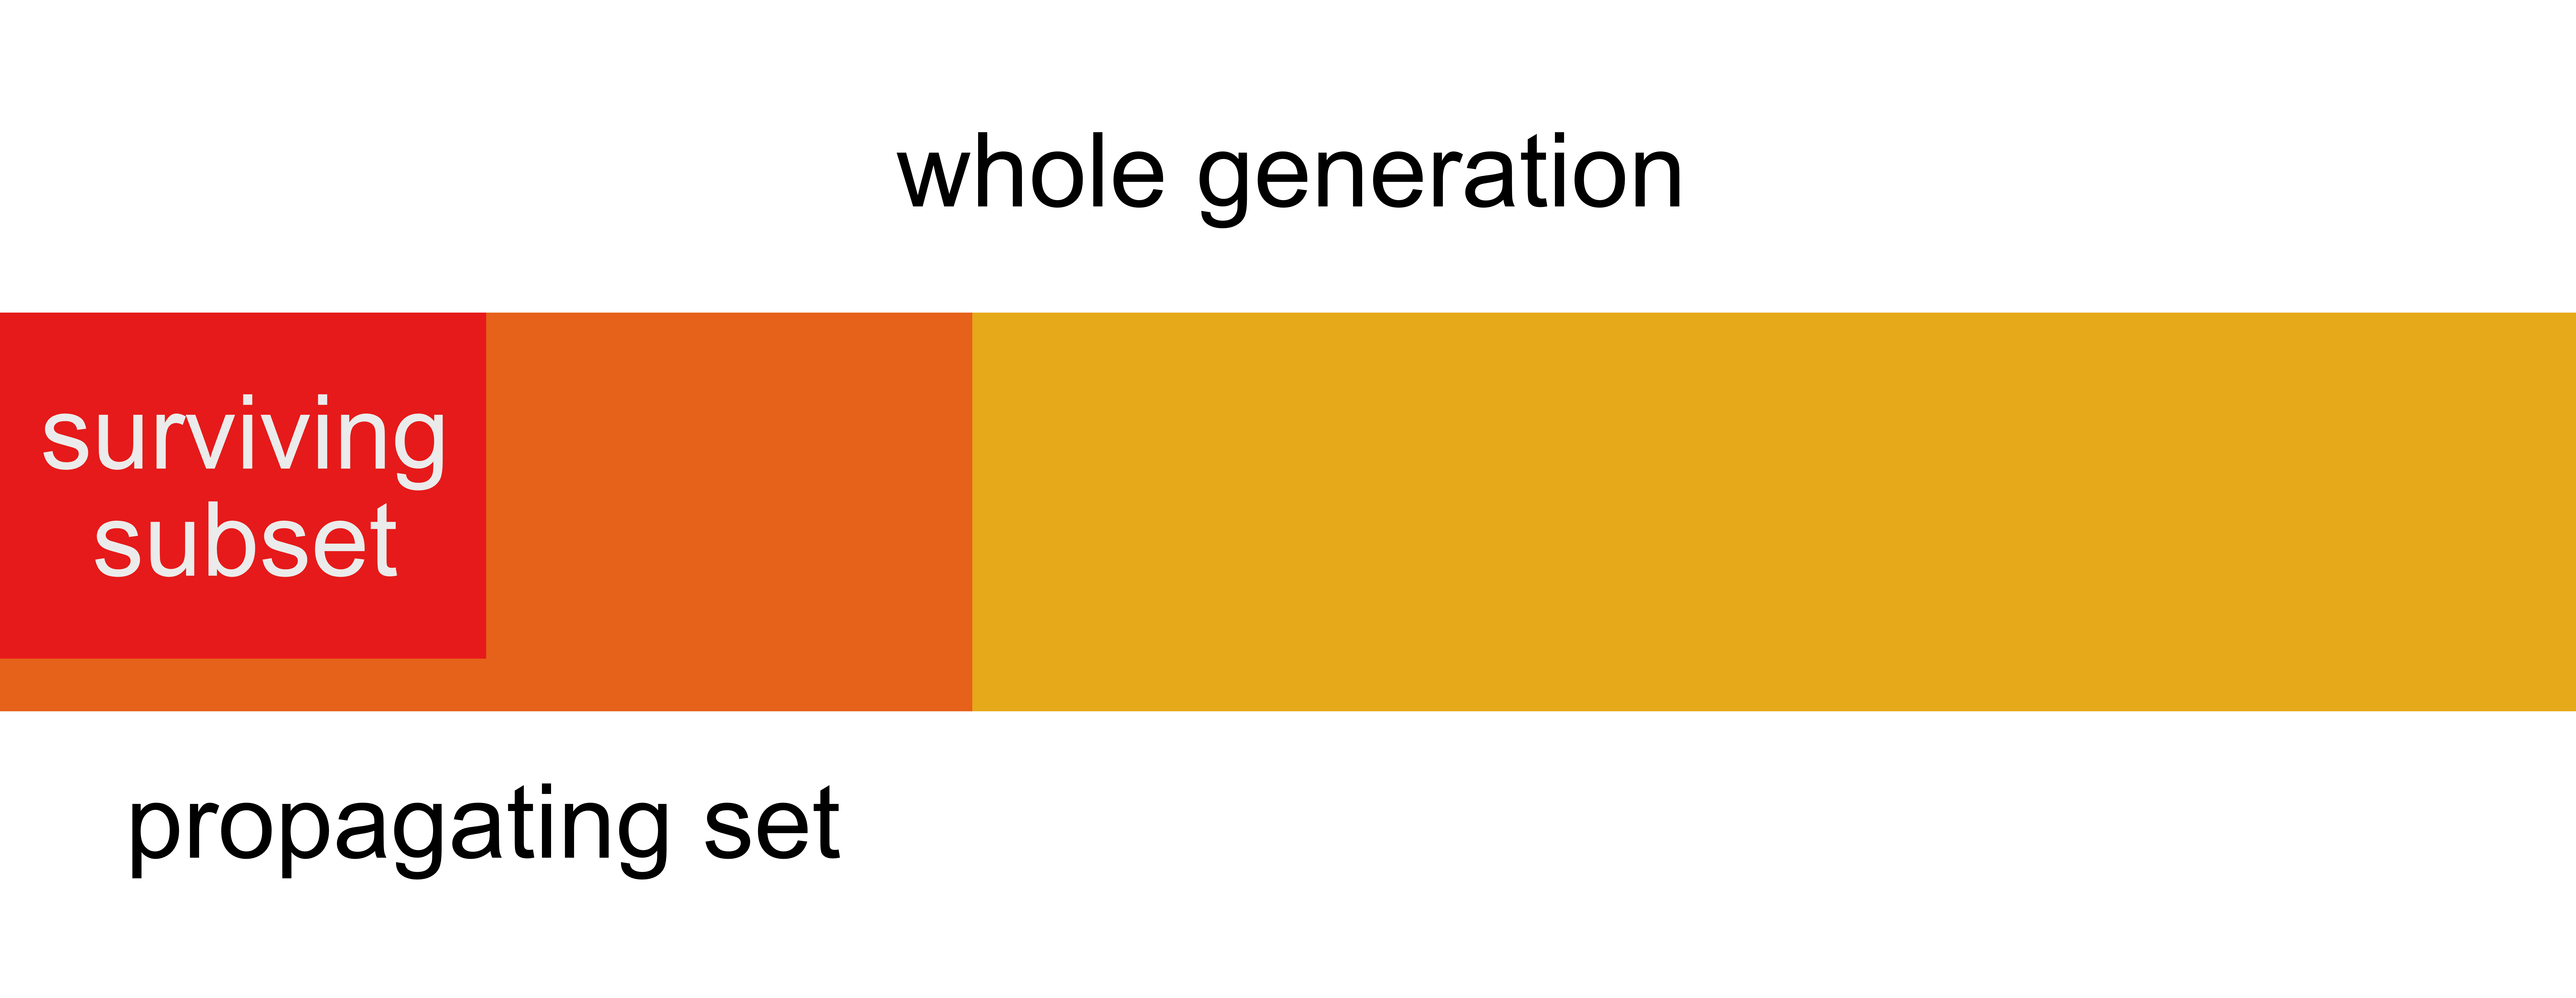

In this implementation, the children of any given set of parents doesn't make up a higher proportion of the new generation, i.e. if some parent set preforms an average of 5 times better than the next parent set, it's children aren't $5 *constant$ times more prevelant in the next generation. The parent sets are simply itterated over until the needed population size is met.


Because proportional propagation isn't implemented, parent sets were selected from a central split of the top performing subset, meaning in a breeding population of 100, pairings are implemented as: $$[parent 1 : parent 51], [parent 2 : parent 52], ... , [parent 50 : parent 100]$$ 

This creates a "fair" combination of parents, assuring a consistent difference in score ranking between parents, rather than an unfair penalty on top performing parents if they were paired with lowest parents (A) or failing to bias in favour of top preformering parents by not rewarding their better preformance (B);
$$A: [parent 1: parent 100], [parent 2: parent 99], ... , [parent 50: parent 51]$$  $$B: [parent 1: parent 2], [parent 3: parent 4], ... , [parent 99: parent 100]$$


New agents gain the entire chromosome of parent1, up to a random position. From that random position onwards, the rest of the chromosome is contributed by the second parent, shown below. With only 34 agents in every generation, I think it is unlikely that highly distinct strategies will emerge. Because of that, and the fact that the top preforming agents are retained into the next generation, I'm happy merging chromosomes like this, in a way which may create unoptimal combinations of genes. Other combinations will be achieved later, as the agents are recombined, with new random splits.

$$parent_1 = [a_1, b_1, c_1, d_1, e_1]$$
$$parent_2 = [a_2, b_2, c_2, d_2, e_2]$$
$$ random position = 2$$
$$child_1 = [a_1, b_2, c_2, d_2, e_2]$$

***Determining Actions:***

A fairly highlevel abstraction was chosen for determining which action an agent should take. Each percept layer was kept seperate, rather than being merged into one large vector/tuple. 
In the style of a "look-ahead" algorithm, agents evalutate their potential position in each possible direction of travel (up, down, right, left). The agent does not calculate the potential moves of other agents, and only looks ahead one move, so it's not a true look-ahead implementation. 

In evaluating the value of being in any of those given squares, the agent considers everything it sees on each percept layer as if it was in that potential position (*Distance is counted as a manhattan distance, as creatures can only ever travel along gridlines*).
- For the agent map, it considers the size of every agent it sees, the attitude of those agents, the distance to those agents, and the difference in size between it and the observed agent.
- For the food map, it considers every piece of food it sees, the agent's own size and the distance to that piece of food.
- For the wall map only distance to each wall is calculated

Additionally, if the agent is over a piece of food, the agent considers if it should remain on that square and spend the turn consuming the resource.
The action which gives the maximum reward (numerical value) is the action the agent takes (action vector uses "one-hot encoding, corresponding to maximum value of action vector)

All of these evalations are multiplied by weights, which are the mutating genes of every agent. The following are the formulae of the considerations, and their weights:
- *attitude of agent * weight(attitutude) * size of agent * weight(size) + (weight(size | attitude) * size * attitude of agent)*
- *weight(distance from agent) * distance from agent * weight(attitude)*
- *(weight(size) * size of agent * weight(attitude) * attitude) * (weight(distance) * distance)*
- *(weight(size difference) * size difference) + weight(attitude) * attitude + (size difference * attitude * weight(size | attitude))*
- *(weight(size difference) * size difference) * ((weight(distance) * distance) * (attitude of agent * weight(attitutude)) * (size difference * attitude * weight(size | attitude))* 


- *weight(distance to food) * distance to food*
- *weight(distance to food | agent's own size) * (distance to food / agent's own size)*

- *weight(distance from wall) * distance from wall*


- *weight(consume food agent is on top of)*

One of the key terms in these calculations is the interaction term, and it's corresponding weight; a|b.
These terms allow for non-linear interactions to occur, meaning behaviour can be more complex than the linear addition or multiplication of two weights.

    i.e. the size|attitude weight allows agents to develop behaviours that are not just opposites for two agents of the same size on different sides, but rather to create different behaviours depending on the value of these two variables. Perhaps it's not always good to move towards to large friendlies, the opposite of running from big enemies

***Evolution of agents:***

Two models of evolution were trialed, the first being a simple one, where if a random variable fell below the mutation threshold, a gene was changed to an entirely random value, within a range which was also a gene that could mutate, allowing the algorithm to promote or penalise mutation. 

The second mutation scheme was based on the standard deviation of the gene in question. Rather than have the genetic algorithm's selection process implictly change the mutation rate, mutation of a gene always occurs, within ±(std/2). If the standard deviation of a given gene drops too low, then the first mode of mutation described above kicks in. This failsafe catch helps prevent gene values from falling into stable but not beneficial values. It is necessary, as itterative selection and resampling with less variation at each step (std$_2$ = std$_1$/2) will naturally converge values around the central value of a normal distribution. 

These images show the algorithm discovering it can change the mutation degree. The standard deviation of at least one gene got low enough that it triggered the failsafe, as a result this gene "entered the model."

***Mean value of mutation rate:***

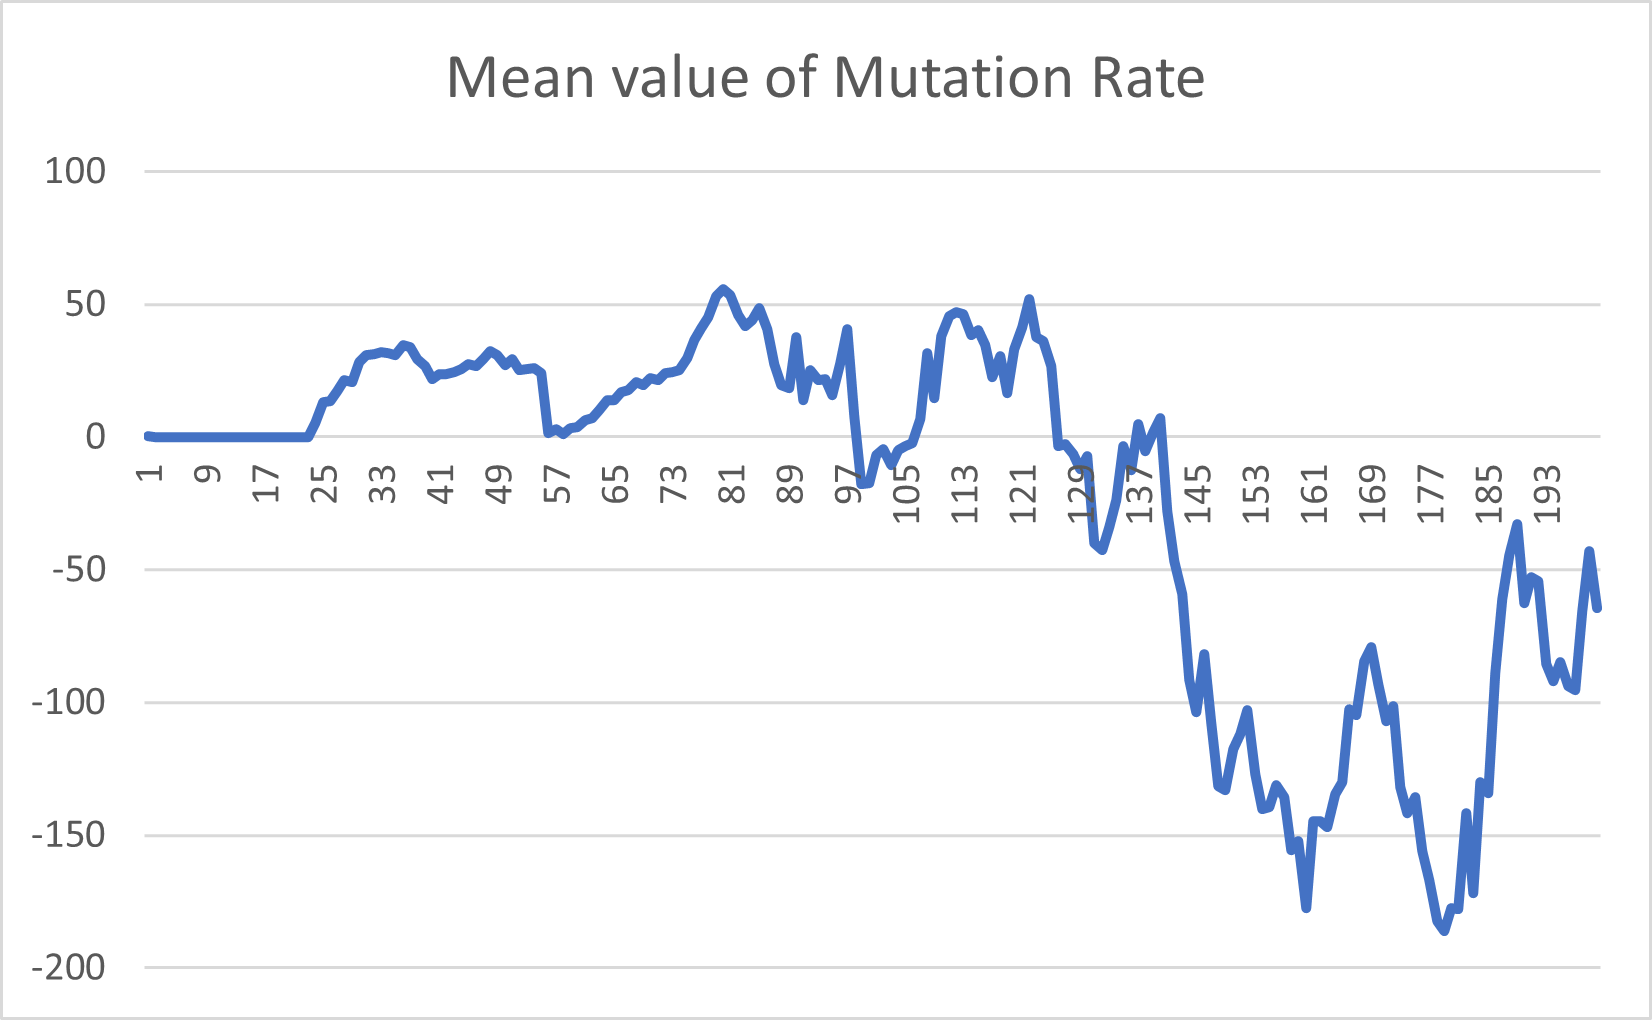

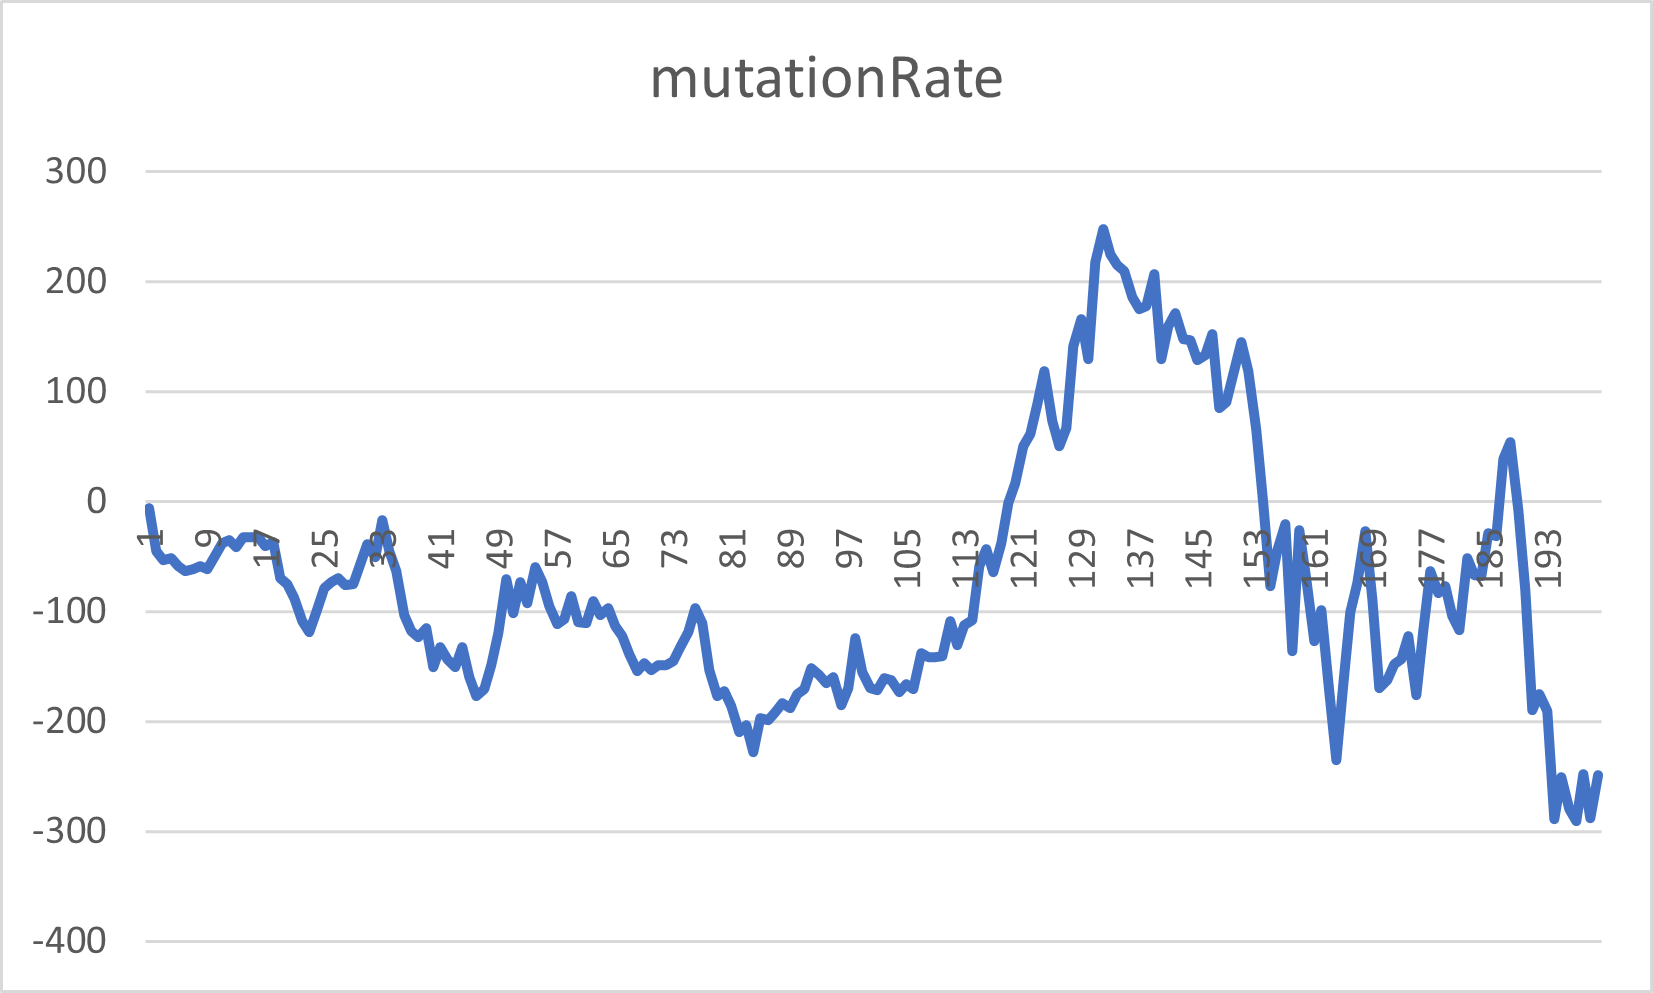

***Standard Deviation of Mutation Rate***

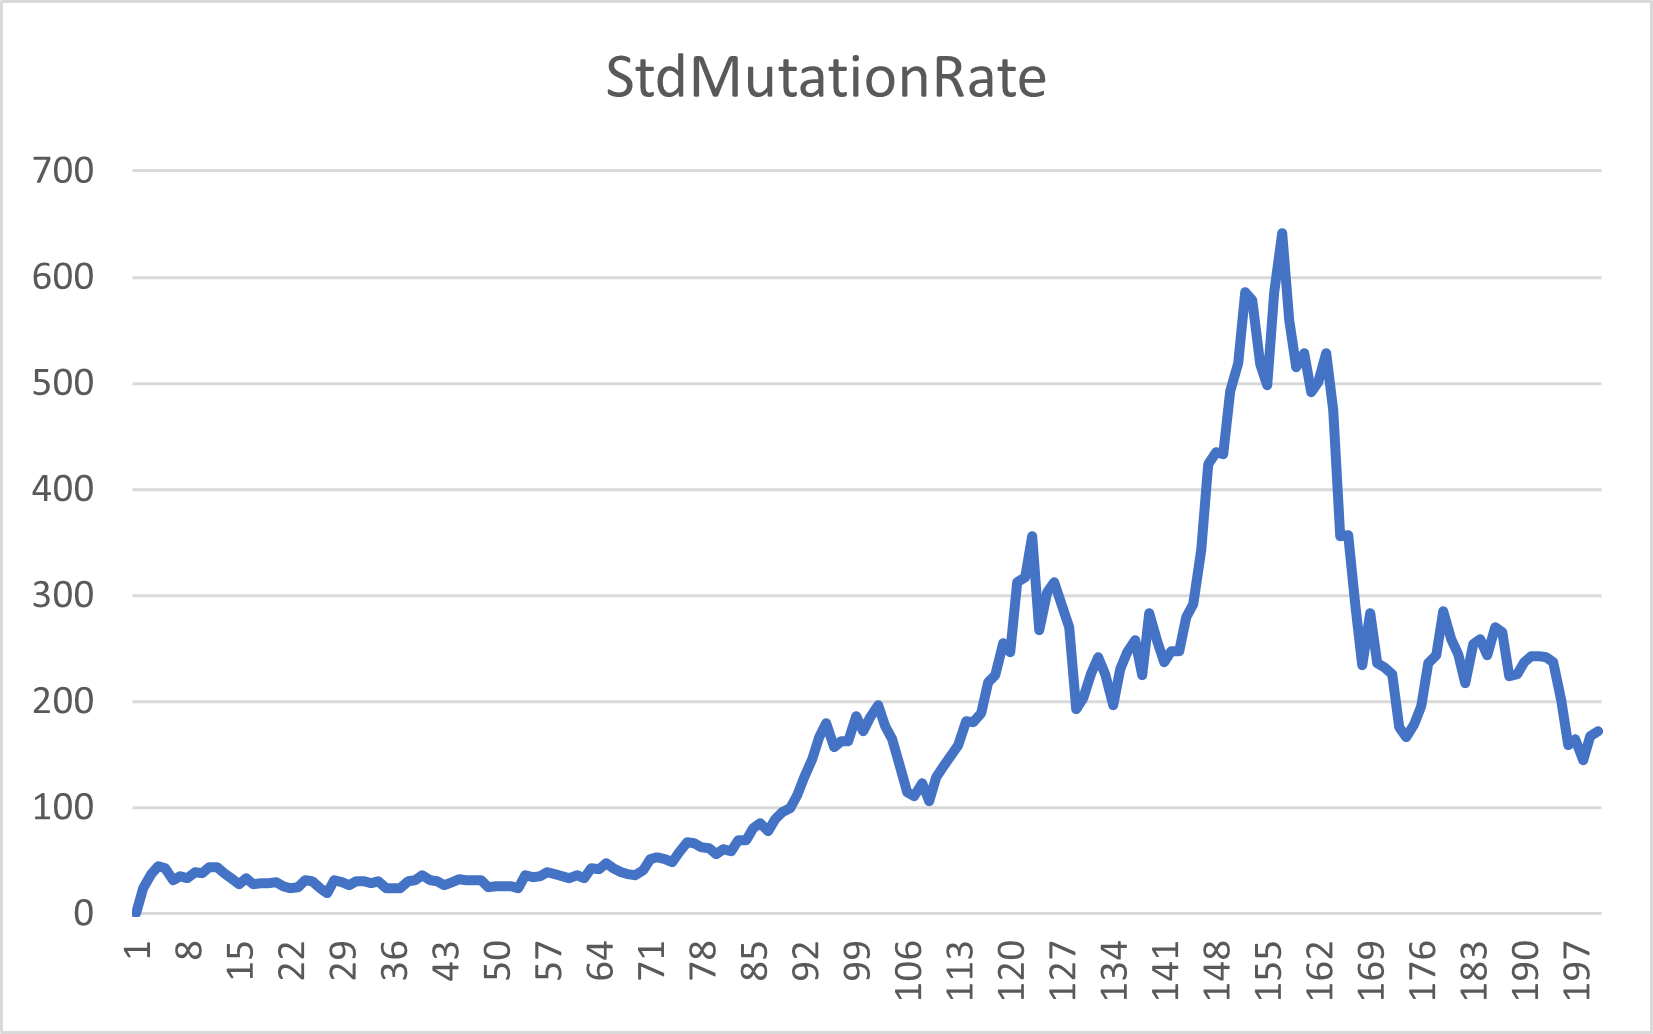

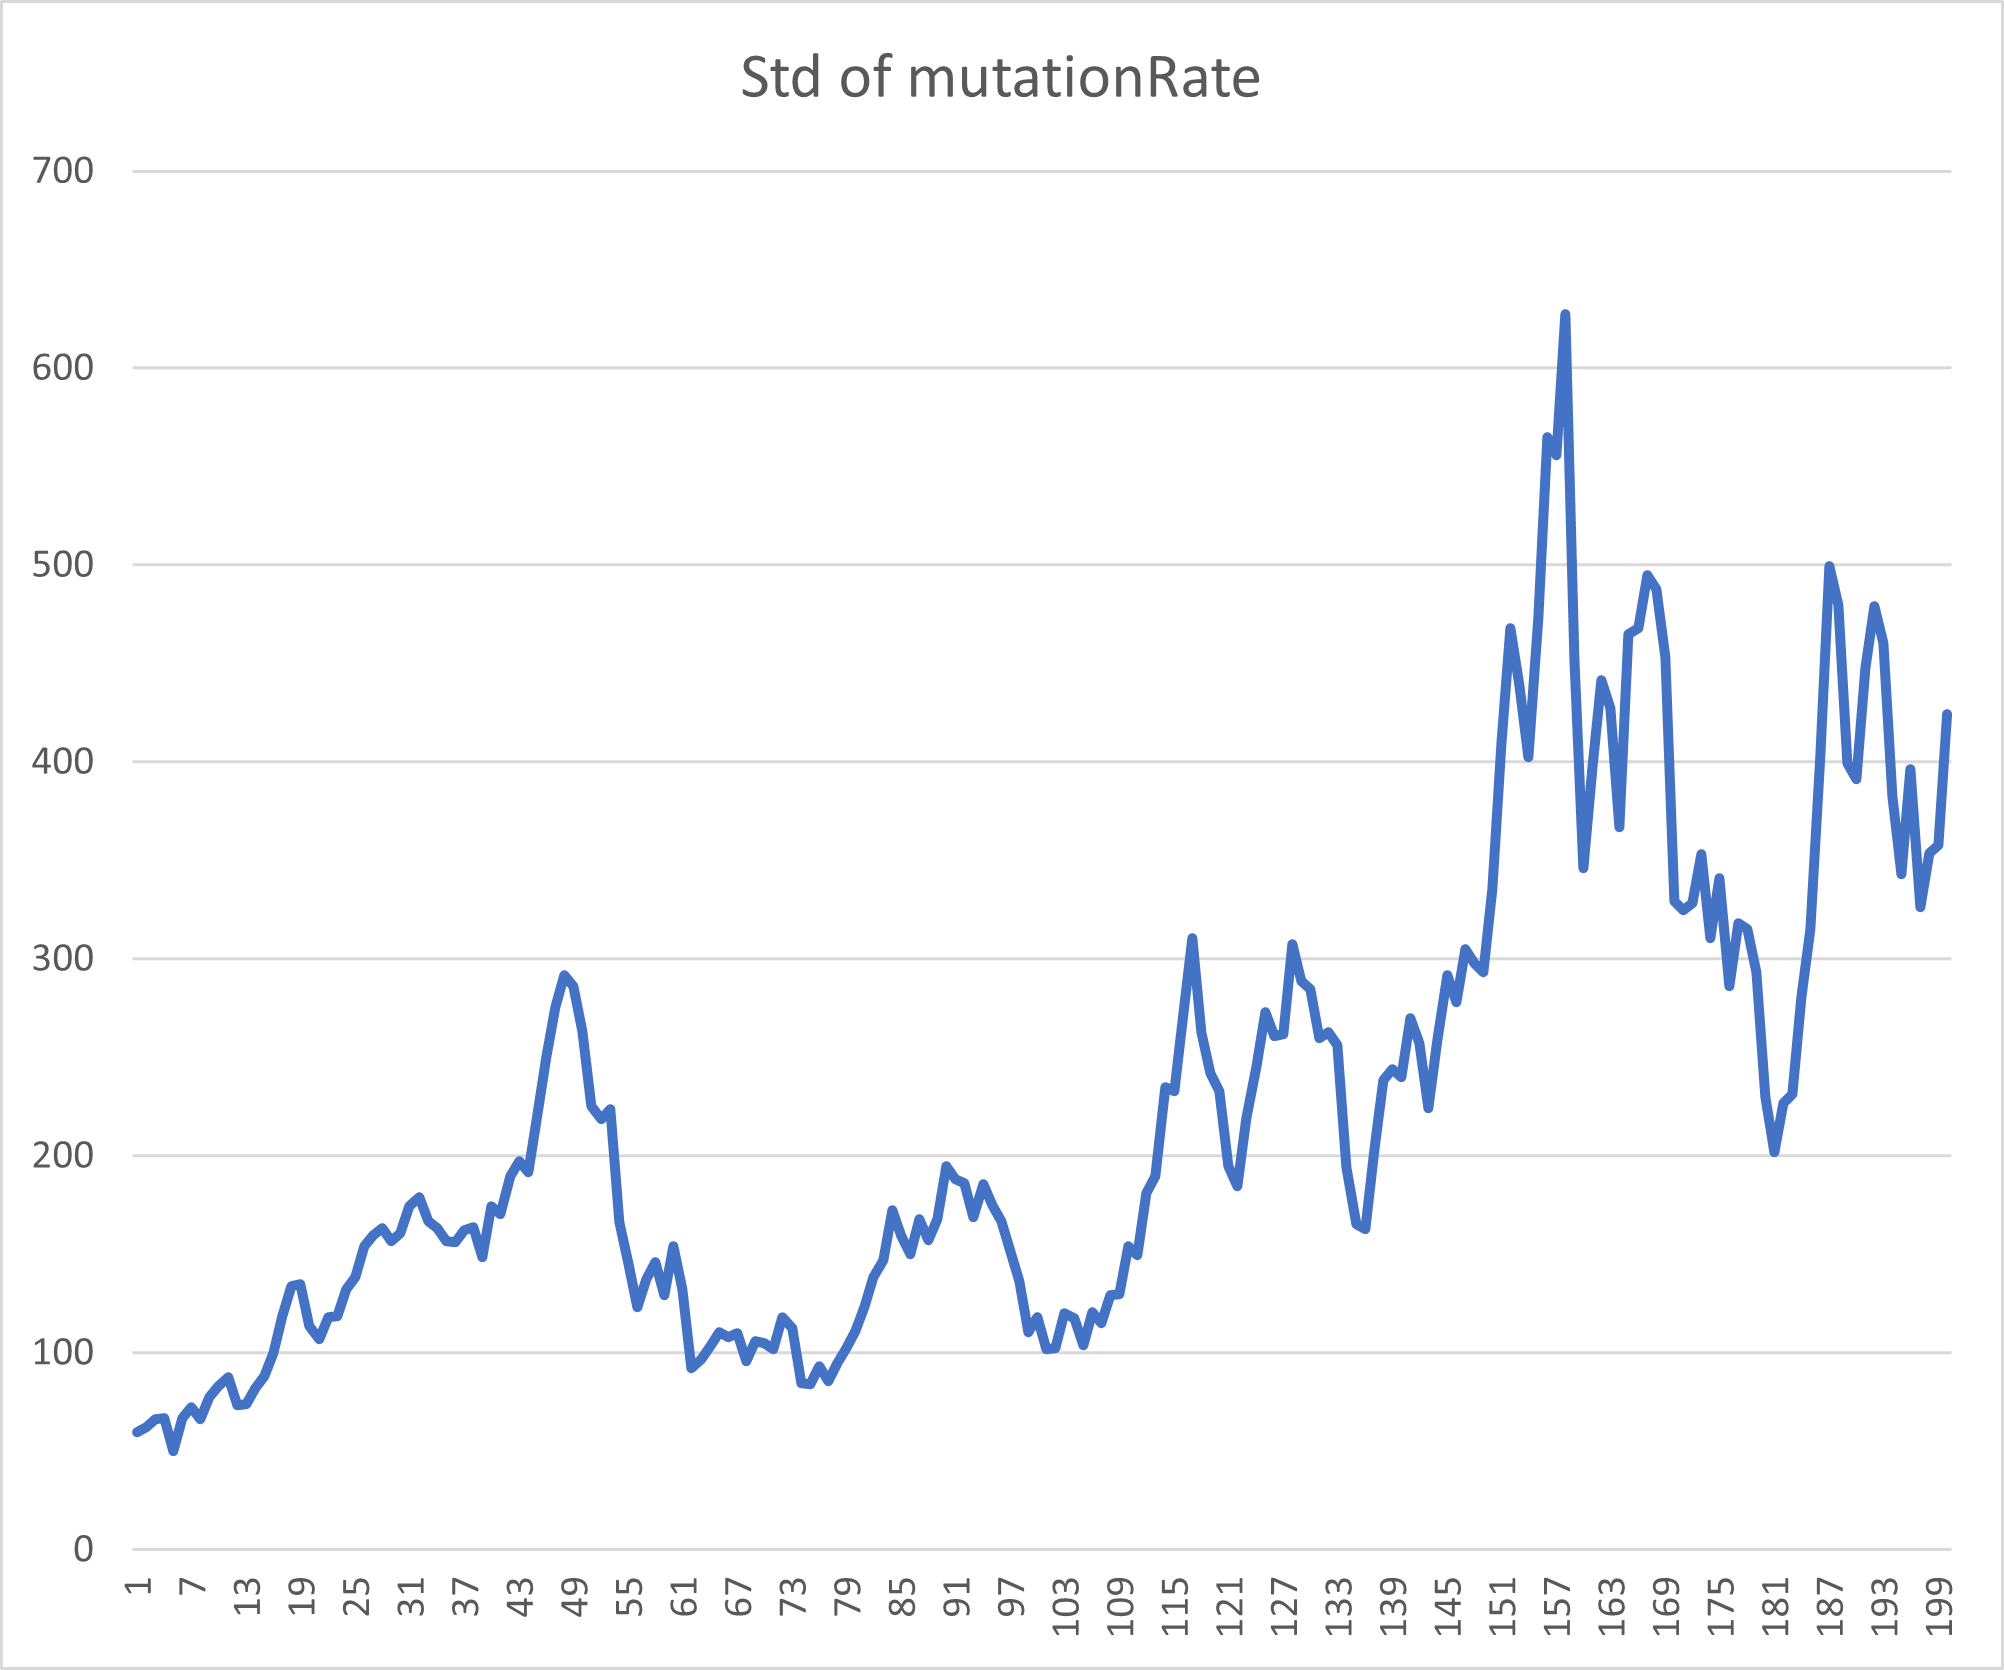

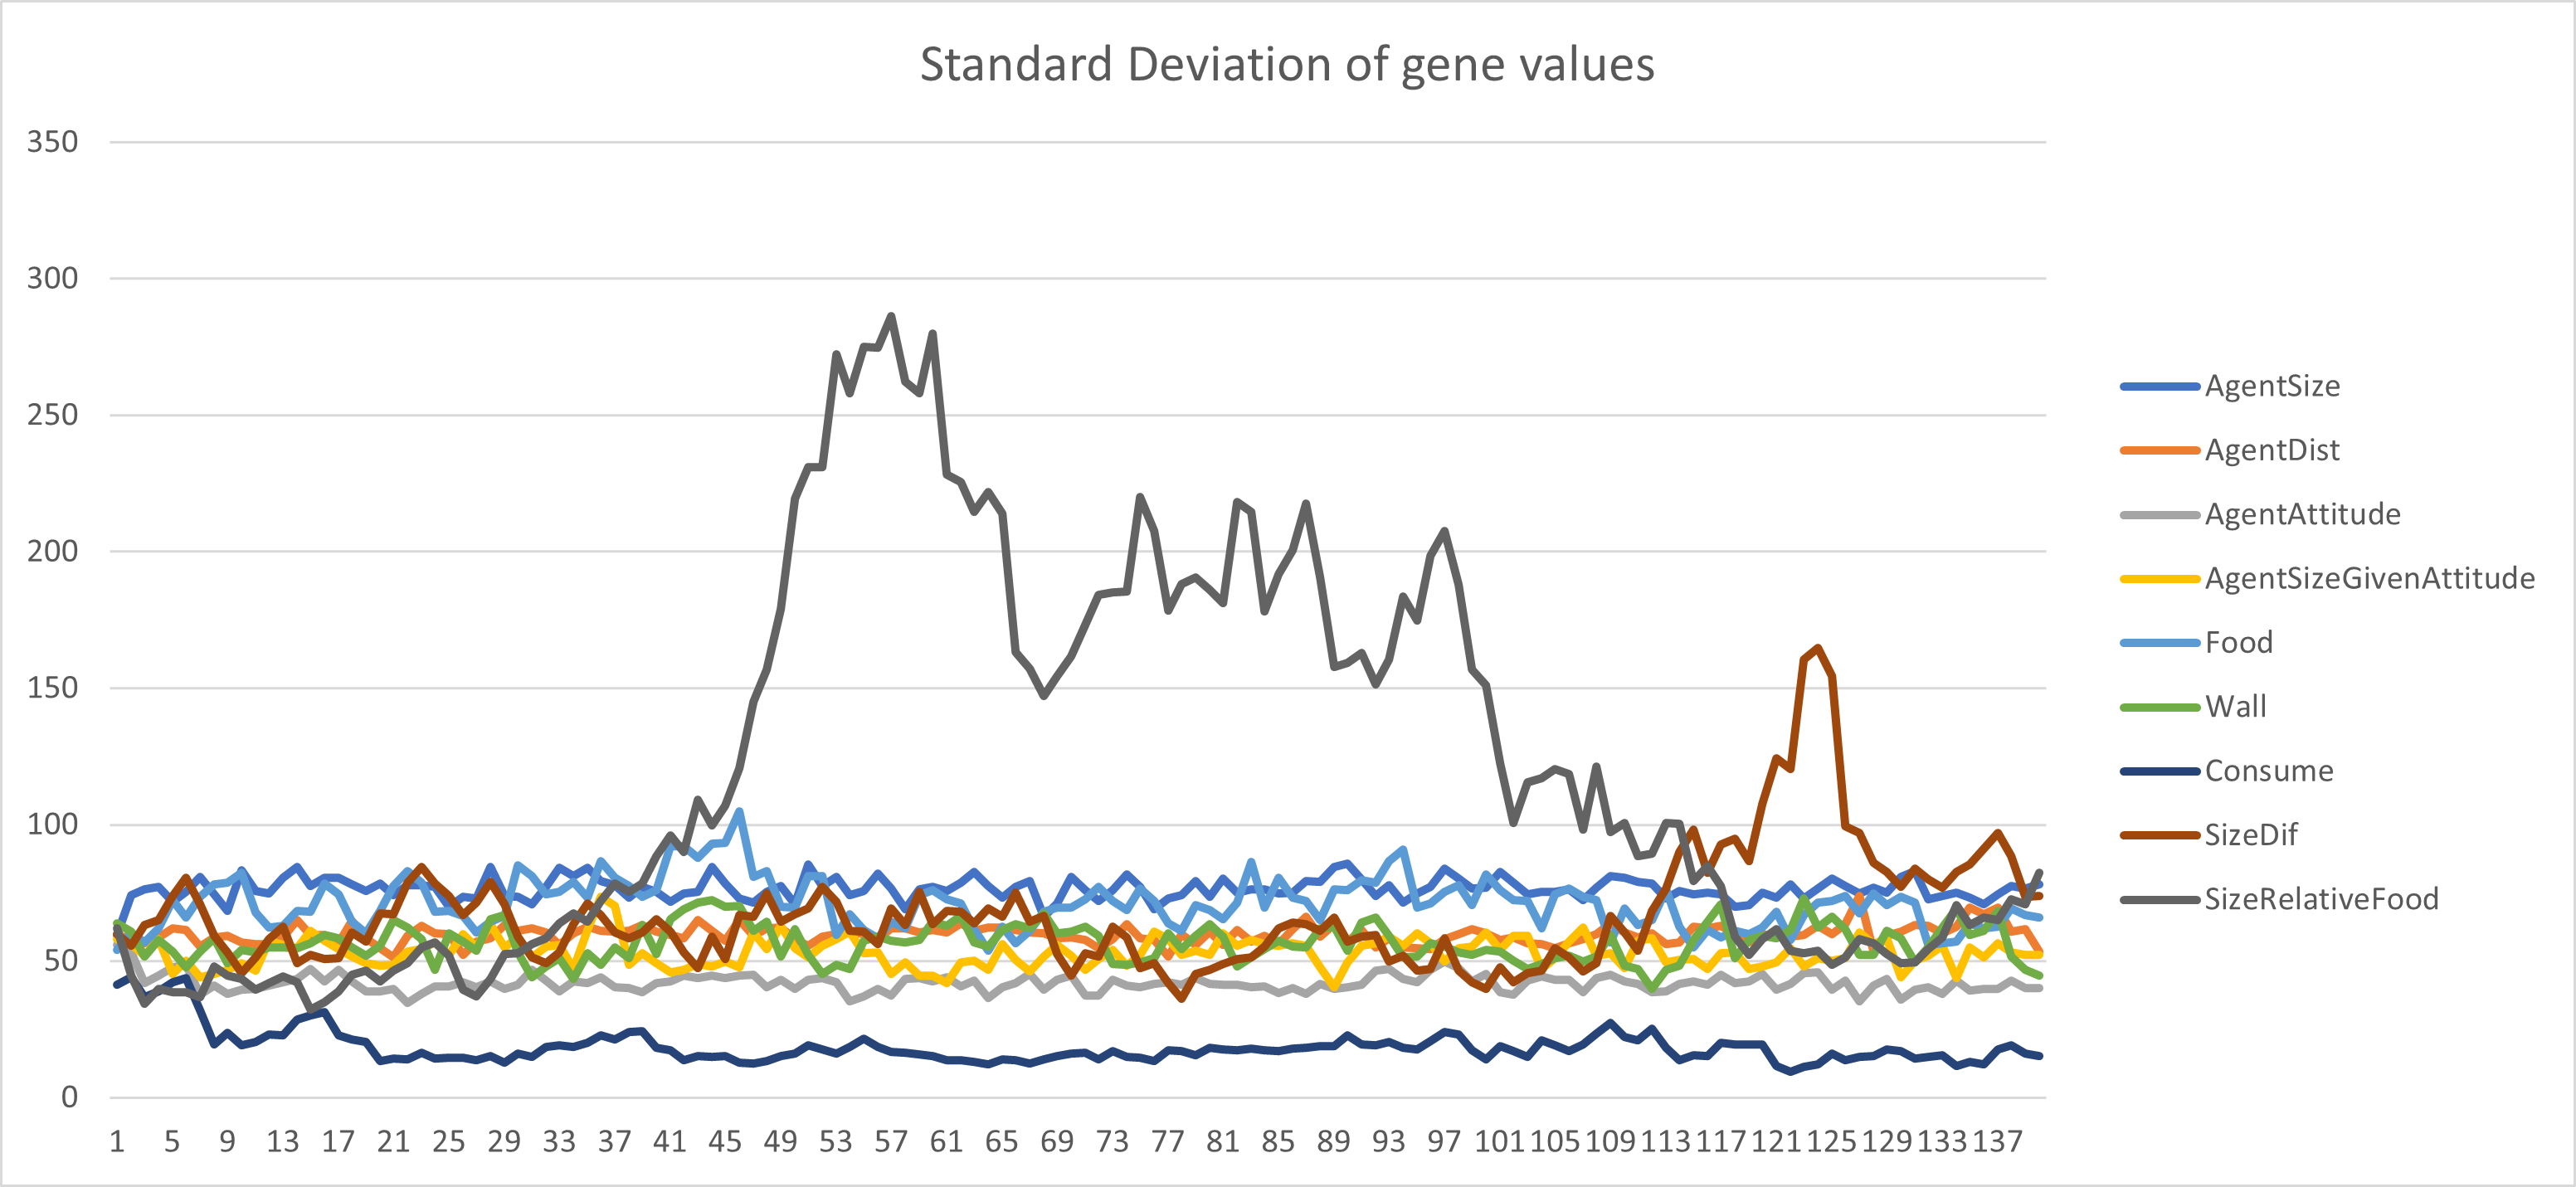

Based on the standard deviation, we can see that some gene's are optimised when they're stable around a single value, where others can vary a lot, showing they are largely irrelvant to the model's success, as they are not subject to selection pressures.

***Evaluating fitness***

A variety of fitness functions were considered, each rewarding different things. Inital functions rewarded length of time survived and the number of things the agent had eaten. Unfortunately this heavily incentivises hidding from other agents, moving back and forth between two squares. This jittery movement becomes the dominant strategy, and agents never learn that eating allows them to grow, and then eat other agents.

To fix this, later fitness functions incorporated a term rewarding the agent for visiting previously unseen squares. Rewarding exploration helps reduce the amount of turns spent in the same area, but does not totally eliminate it if other terms are included in the fitness function.

By changing the coefficents in the fitness function different strategies can be promoted. Highly valuing *creature.enemy_eats* encourages an aggressive behaviour, while promoting *creature.strawberry_eats* encourages food consumption over eating other agents.

I did play with only considering the scores of surviving agents, however in a game where most agents are killed this leads to tiny genetic diversity in subsequent generations, and also fails to reward agents who eat multiple enemies, and then die: *An agent who consumes 5 enemy agents, and is then eat by an enemy who only eaten food has contribute a net $-4$ to population count in it's sides' favour.* As such I have not pursued more of this style of function.

Other fitness functions tried rewarding all agents, but more heavily applying that reward to surving agents. This did not have a noticable effect, as suriviving agents already had higher *creature.turn* values than those that did not.

The final fitness function rewards survival, consumption of both agents and food, exploration. It also rewards size at an exponential rate, as getting to size 4 is not one step up from size 3. Additionally, it includes a final term which penalises agents for bumping into friendly agents or walls. This was included to discourage agents from immediately clumping up with friendlies, without first increasing their size by finding and consuming food/enemy agents.

**The function is defined as follows:**

    fitnessEval2 = turns survived + strawberries eaten + enemies eaten + squares visited
    fitnessEval7 = fitnessEval2 + size^2 - (bounces/squares_visited)

**Comments and Considerations**

Training against the random player for too long doesn't seem to produce a clever agent. Around epoch 20 the agent is doing well, but then it becomes noisey and unstable up to at least epoch 100. Rather than long sessions against the random player, short stints against the random (to establish game basics), and then sessions against the more dangerous hunter player, seem to generate a clever agent, who consistently beats the random player. 

Despite the agent not winning against the hunter player, the more hostile conditions appear to push the algorithm towards a more sophisticated behaviour set, whereas the conditions against the random player allow for pseudo-effective behaviours to still be rewarded, as the enemy is not making optimal decisions either. *(Against "Hunter player" between rounds 20:100)*

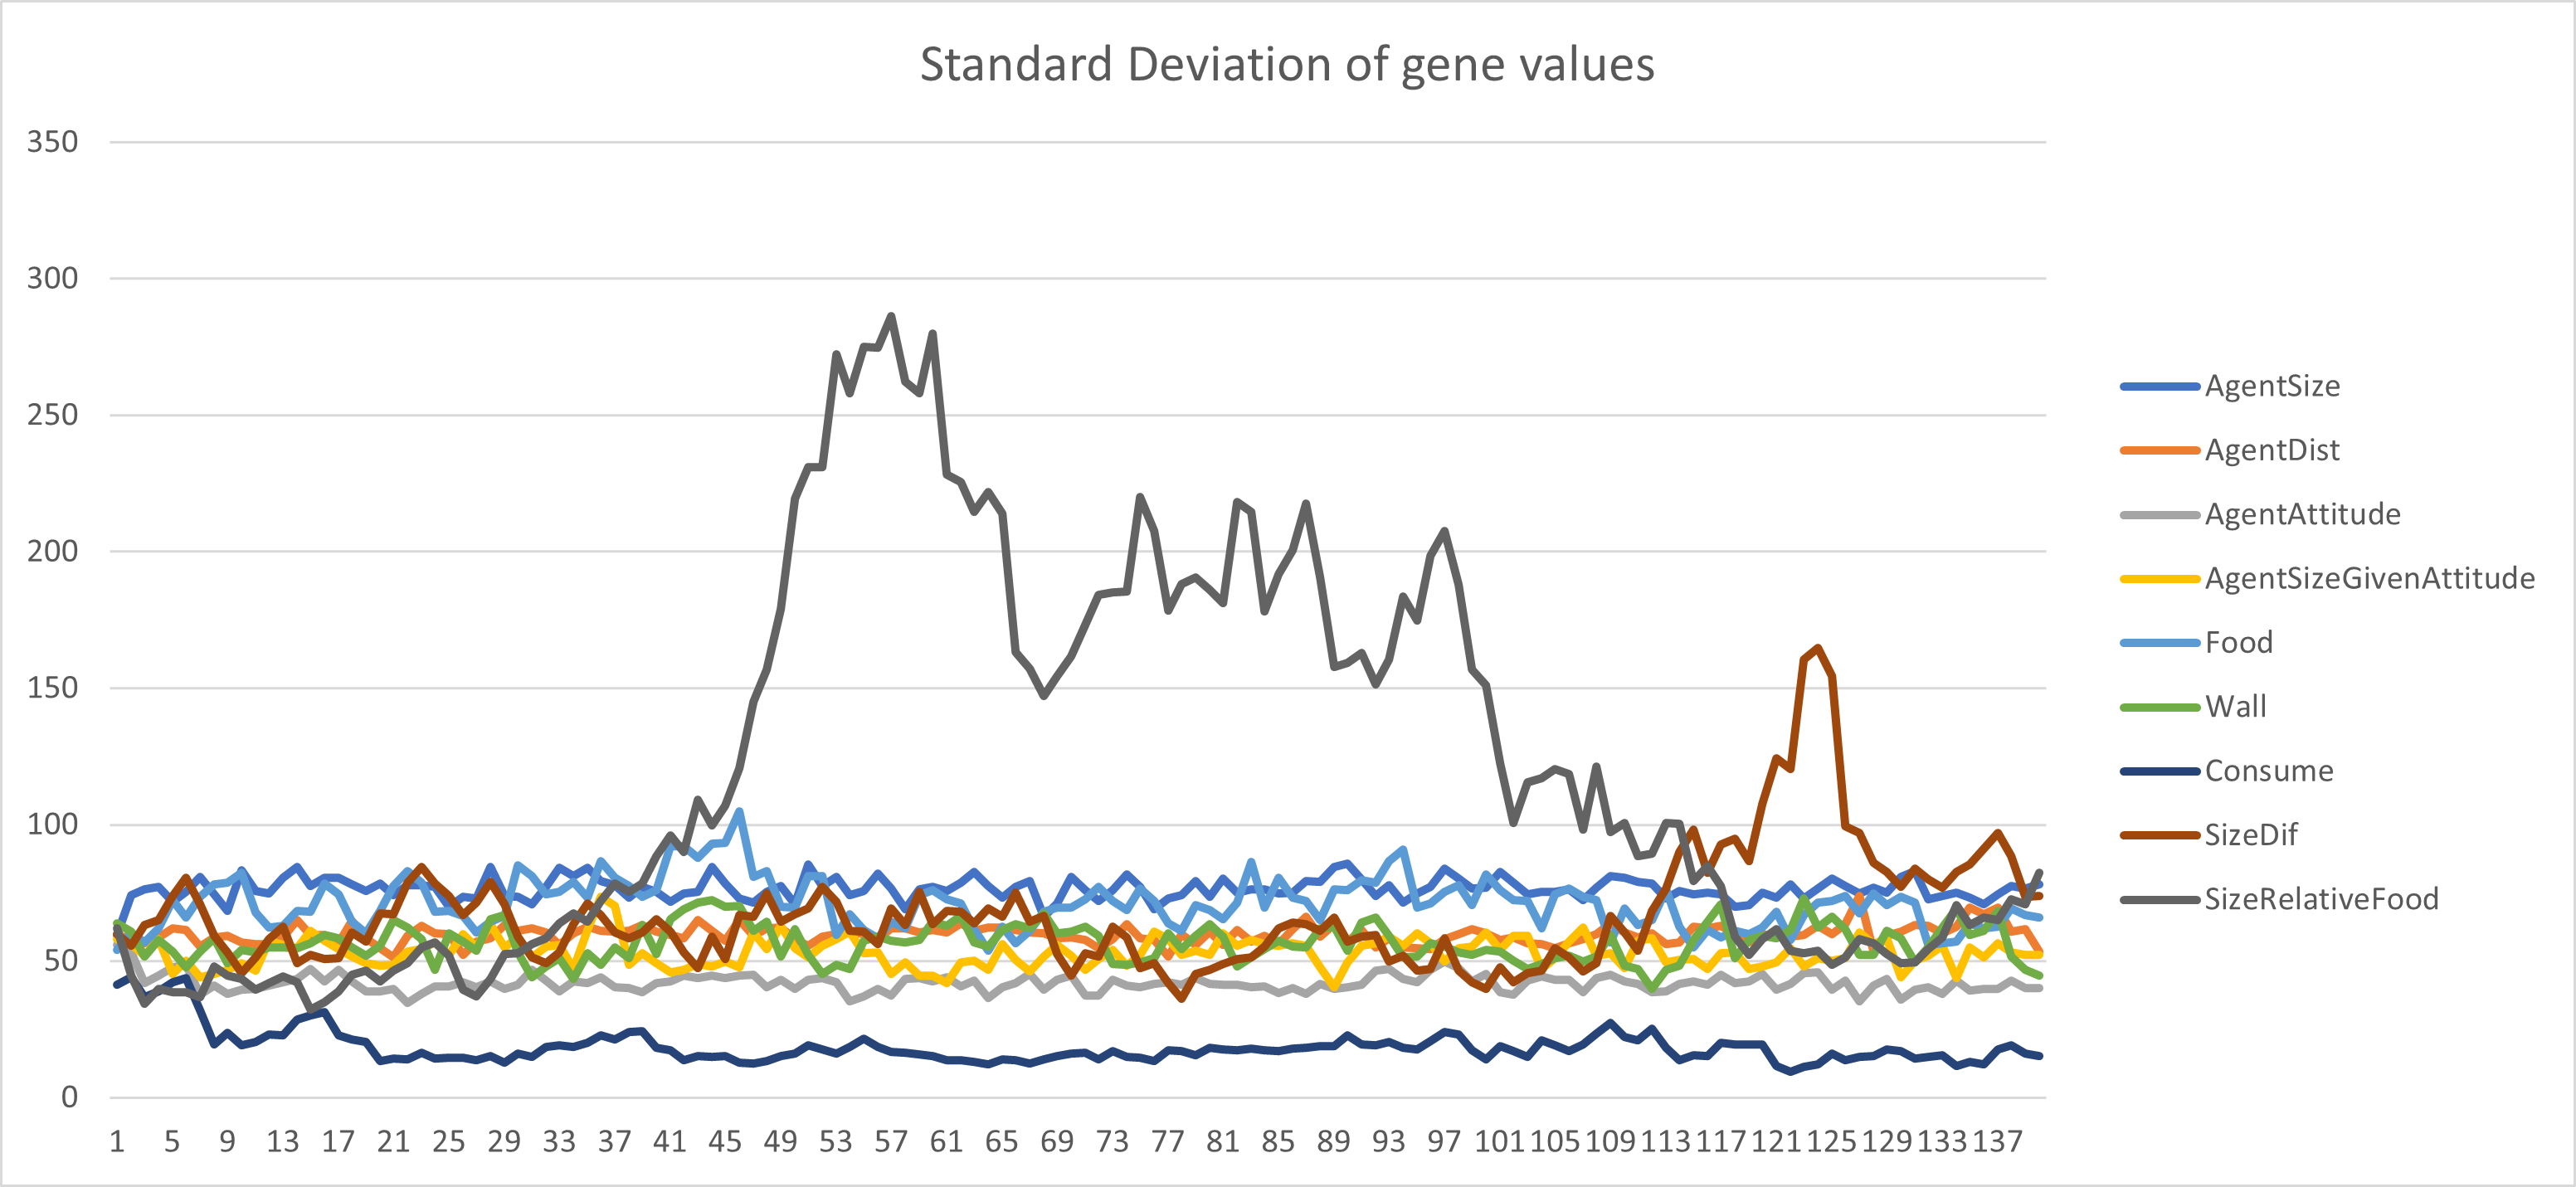

Additionally, this agent does not really perceive open space as existing, or having any explicit value. As such, it may not take the optimal route between two squares, especially if the weight for distance to walls has become unstable, and thus largely irrelevant to the model. 